<h2>EXTRACT TRANSFORM LOAD NOTEBOOK</h2>

The below code-block is to integrate the notebook with the appropriate *project token* so as to work with the project resources.

In [1]:
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='d1984fed-cb78-41cc-8200-6da99fbb08fb', project_access_token='p-32a6b51793a0b69d990e55227d0a1bb1cfc0a2f8')
pc = project.project_context


Let's start by installing PySpark.

In [2]:
#Install PySpark
!pip install pyspark==2.4.5

Now we can import the necessary libraries for ETL.

In [3]:
#Import necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

Apache Spark requires a session initialization before reading the data. Hence, let's create a Spark session.

In [4]:
#Create Spark instance

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Now let's download the data from my GitHub repo into the notebook path.

In [5]:
#Download data from GitHub as a parquet file

!wget https://github.com/soundarzozm/Iot-Sensor-Data/raw/master/df.parquet?raw=true
!mv df.parquet?raw=true df.parquet

--2020-08-18 10:13:34--  https://github.com/soundarzozm/Iot-Sensor-Data/raw/master/df.parquet?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/soundarzozm/Iot-Sensor-Data/master/df.parquet [following]
--2020-08-18 10:13:35--  https://raw.githubusercontent.com/soundarzozm/Iot-Sensor-Data/master/df.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6169715 (5.9M) [application/octet-stream]
Saving to: ‘df.parquet?raw=true’

100%[======================================>] 6,169,715   --.-K/s   in 0.08s   

2020-08-18 10:13:36 (76.3 MB/s) - ‘df.parquet?raw=true’ saved [6169715/6169715]



Since the dataset is now present in the notebook path, it is time to read the dataset using Apache Spark and create a dataframe instance of the dataset.
Let's name the dataframe as df and the dataset as sensor_data.

In [6]:
#Create a spark dataframe out of the parquet file
df = spark.read.parquet('df.parquet')

#Create an instance of the dataset and name the table as sensor_data
df.createOrReplaceTempView('sensor_data')

#Print the statistical description of the dataframe
df.describe().show()

+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|           device|                  co|          humidity|                 lpg|               smoke|              temp|
+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              405184|           405184|              405184|            405184|              405184|              405184|            405184|
|   mean| 1.594858017296766E9|             null|0.004638844633115907| 60.51169396157919|0.007237125655060...|0.019263611784846313|22.453987345642783|
| stddev|  199498.39926615136|             null| 0.00125002628348539|11.366489390798012|0.001444115678768...| 0.00408613006012218|2.6983469512633156|
|    min|1.5945120943859744E9|00:0f:00:70:91:0a|0.001170508548437...| 1.100000023841858|0.0026934786

From the **Data Exploration** notebook we concluded that *Device 3* is most appropriate to work on.<br>
<br>
Hence, we create a new dataframe with only that particular device's values and perform further analysis.<br>
Let's also print the first 20 records of the dataframe to confirm.

In [7]:
#Create a new dataframe df_3 having data only from the third device
df_3 = spark.sql("SELECT * from sensor_data where device = 'b8:27:eb:bf:9d:51'")

#Print first 20 records of the dataframe
df_3.show()

+--------------------+-----------------+--------------------+--------+-----+--------------------+------+--------------------+----+
|                  ts|           device|                  co|humidity|light|                 lpg|motion|               smoke|temp|
+--------------------+-----------------+--------------------+--------+-----+--------------------+------+--------------------+----+
|1.5945120943859744E9|b8:27:eb:bf:9d:51|0.004955938648391245|    51.0|false| 0.00765082227055719| false| 0.02041127012241292|22.7|
|1.5945120980735726E9|b8:27:eb:bf:9d:51|0.004976012340421658|    50.9|false|0.007673227406398091| false| 0.02047512557617824|22.6|
| 1.594512101761235E9|b8:27:eb:bf:9d:51|0.004967363641908952|    50.9|false|0.007663577282372411| false|0.020447620810233658|22.6|
|1.5945121054488635E9|b8:27:eb:bf:9d:51|0.004976025118224167|    50.9|false|0.007673241660297751| false|0.020475166204362245|22.6|
|1.5945121091366868E9|b8:27:eb:bf:9d:51|0.004970255764418...|    50.9|false|0.00766

Let's define the correlation matrix function and plot the matrix.

In [8]:
#Import necessary libraries
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#Create label list
labels = ['co', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp']

#Define function that accepts a spark dataframe and returns Correlation Matrix 
def correlation_matrix(dataframe, labels):
    
    #Create mew column called corr_features containing necessary features for the matrix
    assembler = VectorAssembler(inputCols=labels, outputCol="corr_features")
    
    #Call the assembler to create an instance
    df_vector = assembler.transform(dataframe).select("corr_features")

    #Get correlation matrix
    matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0]
    
    #Convert to Python list fornat
    cor_mat = matrix.toArray().tolist()
    return cor_mat

Text(0.5, 1.0, 'Correlation Matrix\nDevice 3')

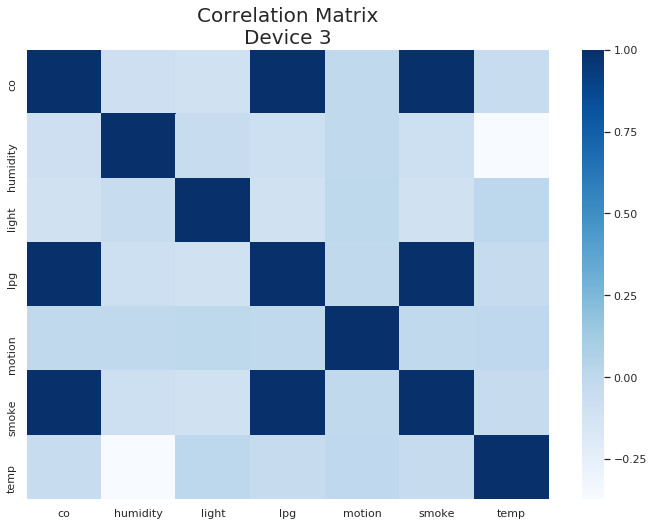

In [9]:
#Plot the Correlation Matrix using Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})
sns.heatmap(correlation_matrix(df_3, labels), cmap="Blues", xticklabels=labels, yticklabels=labels).set_title('Correlation Matrix\nDevice 3')

We notice that **co**, **lpg**, and **smoke** are very highly correlated to each other (as studied from the *Data Exploration Notebook*).<br>
<br>
Hence, we can go ahead and **drop** any two of these features since it would remove redundancy from the data.

In [10]:
#Delete the redundant columns from the dataframe 
df_3 = df_3.drop('co').drop('lpg')

Let's print the dataframe after dropping **co** and **lpg** from the dataframe.

In [11]:
#Display the first 20 records of the dataframe
df_3.show()

+--------------------+-----------------+--------+-----+------+--------------------+----+
|                  ts|           device|humidity|light|motion|               smoke|temp|
+--------------------+-----------------+--------+-----+------+--------------------+----+
|1.5945120943859744E9|b8:27:eb:bf:9d:51|    51.0|false| false| 0.02041127012241292|22.7|
|1.5945120980735726E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02047512557617824|22.6|
| 1.594512101761235E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020447620810233658|22.6|
|1.5945121054488635E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020475166204362245|22.6|
|1.5945121091366868E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02045681960706413|22.6|
| 1.594512112798518E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02042485815208522|22.6|
|1.5945121164982605E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020461237669931027|22.6|
| 1.594512120184931E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020438716650667384|22.6|
|1.5945121238726196E9

That looks great!<br>
<br>
Now, for the next step, we need to convert the *boolean* entries in **motion** and **light** to *integer* values (0 and 1) because *machine learning* requires data in numerical format.<br>
We do this by defining a function which takes a boolean argument and returns the corresponding integer value (0 for False, 1 for True), and then apply this function columnwise and store the output in a new column.

In [12]:
#Define function to convert boolean values to integer values
def bool_to_int(x):
    if x == False:
        return 0
    elif x == True:
        return 1
    else:
        return x

In [13]:
#Import necessary modules
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

#Create a user defined function to be applied on dataframe using the previously defined function
bool_to_int_udf = udf(lambda x: bool_to_int(x), IntegerType())

In [14]:
#Apply the user defined function to the dataframe's light column and create a new column called light_final having integer values
df = df_3.withColumn("light_final", bool_to_int_udf(df_3.light))

In [15]:
#Display first 20 records of the database
df.show()

+--------------------+-----------------+--------+-----+------+--------------------+----+-----------+
|                  ts|           device|humidity|light|motion|               smoke|temp|light_final|
+--------------------+-----------------+--------+-----+------+--------------------+----+-----------+
|1.5945120943859744E9|b8:27:eb:bf:9d:51|    51.0|false| false| 0.02041127012241292|22.7|          0|
|1.5945120980735726E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02047512557617824|22.6|          0|
| 1.594512101761235E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020447620810233658|22.6|          0|
|1.5945121054488635E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020475166204362245|22.6|          0|
|1.5945121091366868E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02045681960706413|22.6|          0|
| 1.594512112798518E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02042485815208522|22.6|          0|
|1.5945121164982605E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020461237669931027|22.6|   

In [16]:
#Apply the user defined function to the dataframe's motion column and create a new column called motion_final having integer values
df = df.withColumn("motion_final", bool_to_int_udf(df_3.motion))

In [17]:
#Display first 20 records of the dataframe
df.show()

+--------------------+-----------------+--------+-----+------+--------------------+----+-----------+------------+
|                  ts|           device|humidity|light|motion|               smoke|temp|light_final|motion_final|
+--------------------+-----------------+--------+-----+------+--------------------+----+-----------+------------+
|1.5945120943859744E9|b8:27:eb:bf:9d:51|    51.0|false| false| 0.02041127012241292|22.7|          0|           0|
|1.5945120980735726E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02047512557617824|22.6|          0|           0|
| 1.594512101761235E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020447620810233658|22.6|          0|           0|
|1.5945121054488635E9|b8:27:eb:bf:9d:51|    50.9|false| false|0.020475166204362245|22.6|          0|           0|
|1.5945121091366868E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02045681960706413|22.6|          0|           0|
| 1.594512112798518E9|b8:27:eb:bf:9d:51|    50.9|false| false| 0.02042485815208522|22.6|

Now that we have the required columns, we can **drop** the old ones. Hence we drop *light* and *motion*.

In [18]:
#Delete unnecessary columns from the dataframe
df = df.drop('ts').drop('device').drop('light').drop('motion')

Let's print the first 20 records of the final dataframe to confirm the application of the necessary transformations.

In [19]:
#Display first 20 records of the dataframe
df.show()

+--------+--------------------+----+-----------+------------+
|humidity|               smoke|temp|light_final|motion_final|
+--------+--------------------+----+-----------+------------+
|    51.0| 0.02041127012241292|22.7|          0|           0|
|    50.9| 0.02047512557617824|22.6|          0|           0|
|    50.9|0.020447620810233658|22.6|          0|           0|
|    50.9|0.020475166204362245|22.6|          0|           0|
|    50.9| 0.02045681960706413|22.6|          0|           0|
|    50.9| 0.02042485815208522|22.6|          0|           0|
|    50.9|0.020461237669931027|22.6|          0|           0|
|    50.9|0.020438716650667384|22.6|          0|           0|
|    50.9|0.020475033620232192|22.6|          0|           0|
|    50.9| 0.02042485815208522|22.6|          0|           0|
|    50.9| 0.02041184473336307|22.6|          0|           0|
|    50.8|  0.0203978759436991|22.6|          0|           0|
|    50.9| 0.02042943583639171|22.6|          0|           0|
|    50.

<h3>Perfect!</h3>
<br>
We observe that the dataframe is has numerical data throughout and the data makes complete sense.<br>
Hence, we can move ahead to feeding this data to machine learning models.<br>
<br>
Let's have a final analysis on the dataframe using statistical description and a correlation matrix. 


In [20]:
# The code was removed by Watson Studio for sharing.

"\nimport ibmos2spark\n# @hidden_cell\ncredentials = {\n    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',\n    'service_id': 'iam-ServiceId-8fc33cc7-939d-43d5-ad00-490be2225f3f',\n    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',\n    'api_key': 'UTFUPhkXyMCWb50A2WJU8KLVXLwgpNd5njjO_EjFLJRV'\n}\n\nconfiguration_name = 'os_13cf4ecbeb27425d8d6bd235f70ba8aa_configs'\ncos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')\n\ndf.write.parquet(cos.url('df_final.parquet', 'capstone-donotdelete-pr-lsmdr68augezqx'))"

In [21]:
#Display statistical description of the final dataframe
df.describe().show()

+-------+------------------+--------------------+------------------+--------------------+--------------------+
|summary|          humidity|               smoke|              temp|         light_final|        motion_final|
+-------+------------------+--------------------+------------------+--------------------+--------------------+
|  count|            187451|              187451|            187451|              187451|              187451|
|   mean| 50.81407674538176|0.022288350217858362|22.279969165276523|0.016009517153816197| 7.68200756464356E-4|
| stddev|1.8889262809920346|0.001720104166737...|0.4819022291417346| 0.12551213707790115|0.027705860735184988|
|    min|              45.1|0.019416273090454256|              21.0|                   0|                   0|
|    max|              63.3| 0.02942197406197568|              24.1|                   1|                   1|
+-------+------------------+--------------------+------------------+--------------------+--------------------+



Text(0.5, 1.0, 'Correlation Matrix')

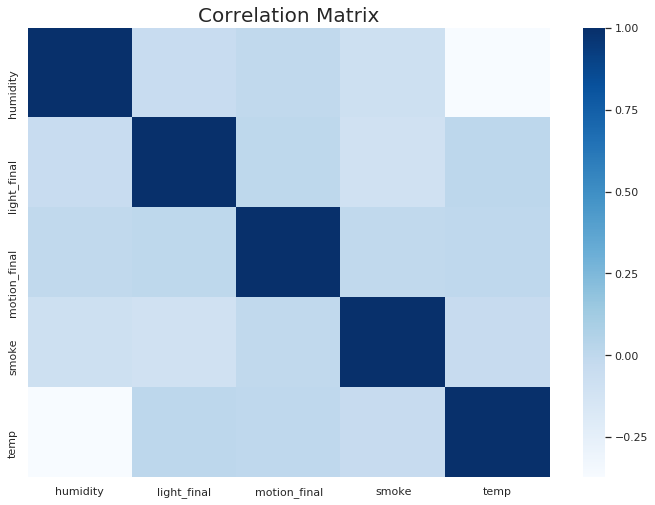

In [22]:
#Define new labels list
labels = ['humidity', 'light_final','motion_final', 'smoke', 'temp']

#Plot the Correlation Matrix using Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27), "axes.titlesize":20})
sns.heatmap(correlation_matrix(df, labels), cmap="Blues", xticklabels=labels, yticklabels=labels).set_title('Correlation Matrix')

We observe that correlation between all the columns are very favourable.<br>
Let's export the dataframe to a parquet file in the notebook path since we'll be using it in the next notebook which is about model definition, training and deployment.

In [24]:
"""project.save_data(file_name = "df_final.parquet",data = df.write.parquet("df_final.parquet"), overwrite=True, set_project_asset = True)"""

'project.save_data(file_name = "df_final.parquet",data = df.write.parquet("df_final.parquet"), overwrite=True, set_project_asset = True)'